In [1]:
import pathlib
import sys

sys.path.append(str(pathlib.Path().absolute().parent))

from src.replay_memory import FastReplayBuffer
from src.env import FourRoomEnvWithTagging
from src.featurizers import PerspectiveFeaturizer, GlobalFeaturizer
from src.visualize import StateSequenceVisualizer

import torch

torch.set_printoptions(precision=3, sci_mode=False, linewidth=200)


In [2]:
BUF_SIZE = 3000
N_IMPOSTERS = 2
N_JOBS = 5
N_CREW = 4
SEQUENCE_SIZE = 2
DEBUG = True

env = FourRoomEnvWithTagging(n_imposters=N_IMPOSTERS, n_crew=N_CREW, n_jobs=N_JOBS, debug=DEBUG)
m = FastReplayBuffer(max_size=BUF_SIZE, state_size=env.flattened_state_size, trajectory_size=SEQUENCE_SIZE, n_agents=env.n_agents, n_imposters=N_IMPOSTERS)
m.populate(env, 1000)

DEBUG - 
New Game Started!
-----------------
    Agent Positions: [(5, 1), (1, 8), (2, 2), (4, 7), (0, 3), (8, 3)]
    Imposters: [1 3]
    Crew Members: [0 2 4 5]
    Alive Agents: [ True  True  True  True  True  True]
    Job Positions: [(1, 3), (3, 1), (1, 7), (0, 7), (3, 7)]
    Completed Jobs: [False False False False False]
    Tag Counts: [0. 0. 0. 0. 0. 0.]
    Used Tag Actions: [0. 0. 0. 0. 0. 0.]
    Time Left for Tag Reset: 50
-----------------
        
DEBUG - Agent 4 ([0 3]) tagged Agent 0 ([5 1])! 0's new tag count: 1.0
DEBUG - Agent 2 ([2 2]) tagged Agent 5 ([8 3])! 5's new tag count: 1.0
DEBUG - Agent 4 tried to tag Agent 5 but failed!
DEBUG - Agent 3 ([6 7]) tagged Agent 2 ([2 2])! 2's new tag count: 1.0
DEBUG - Agent 1 ([1 8]) tagged Agent 0 ([6 0])! 0's new tag count: 2.0
DEBUG - Agent 4 tried to tag Agent 0 but failed!
DEBUG - Agent 2 tried to tag Agent 0 but failed!
DEBUG - Agent 5 ([7 3]) tagged Agent 1 ([0 8])! 1's new tag count: 1.0
DEBUG - Agent 2 tried to tag 

In [3]:
env.state_fields

{<StateFields.AGENT_POSITIONS: 0>: 0,
 <StateFields.JOB_POSITIONS: 1>: 1,
 <StateFields.JOB_STATUS: 2>: 2,
 <StateFields.ALIVE_AGENTS: 3>: 3,
 <StateFields.USED_TAGS: 4>: 4,
 <StateFields.TAG_COUNTS: 5>: 5,
 <StateFields.TAG_RESET_COUNT: 6>: 6}

tensor([[1., 1., 1., 1., 1., 1., 2., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 2., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])


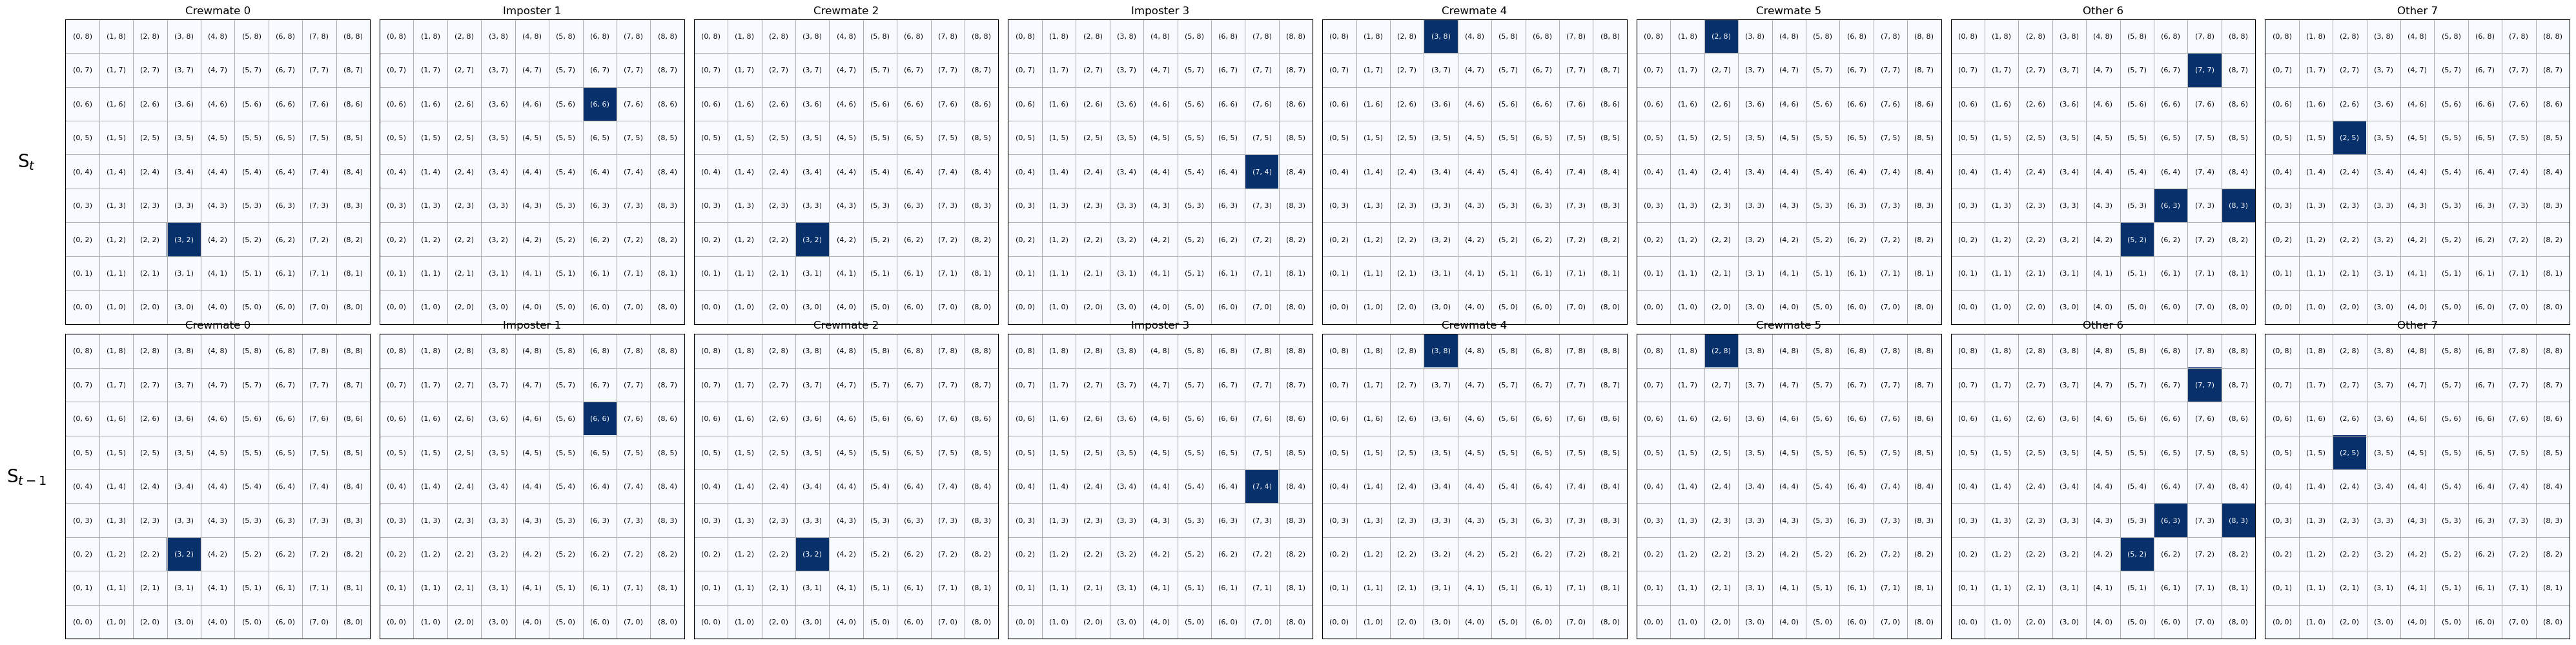

tensor([[1., 1., 1., 1., 1., 1., 2., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 2., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])


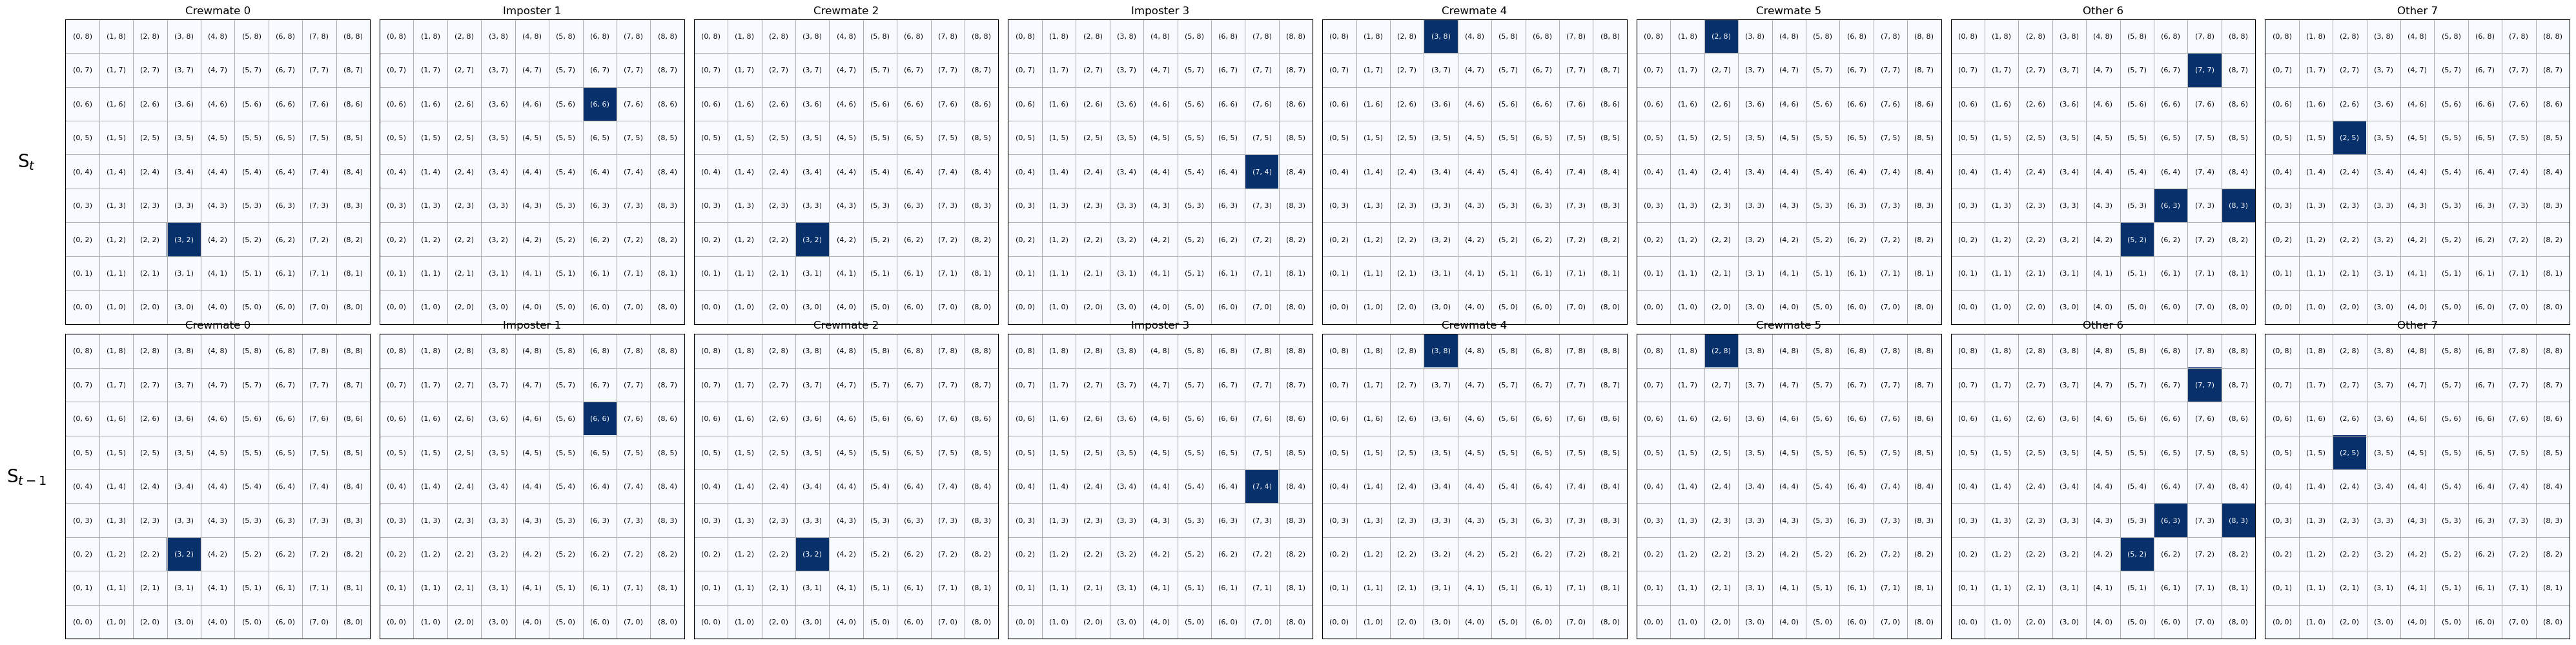

tensor([[1., 1., 1., 1., 1., 1., 2., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 2., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])


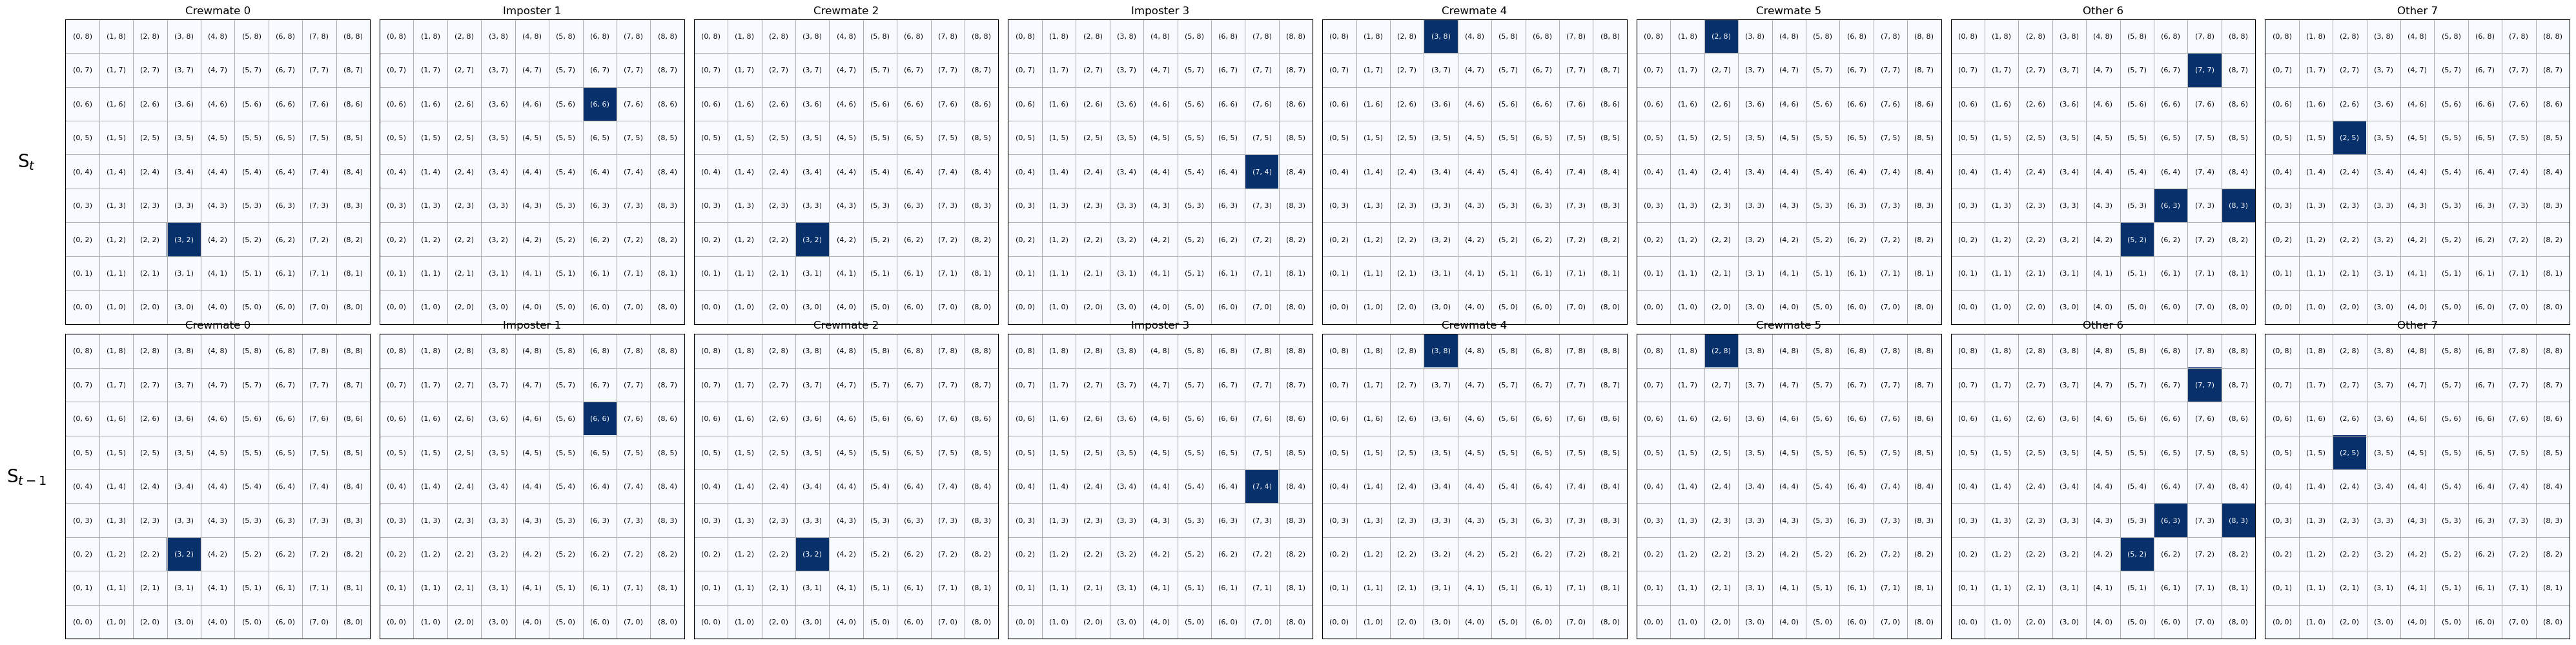

tensor([[1., 1., 1., 1., 1., 1., 2., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 2., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])


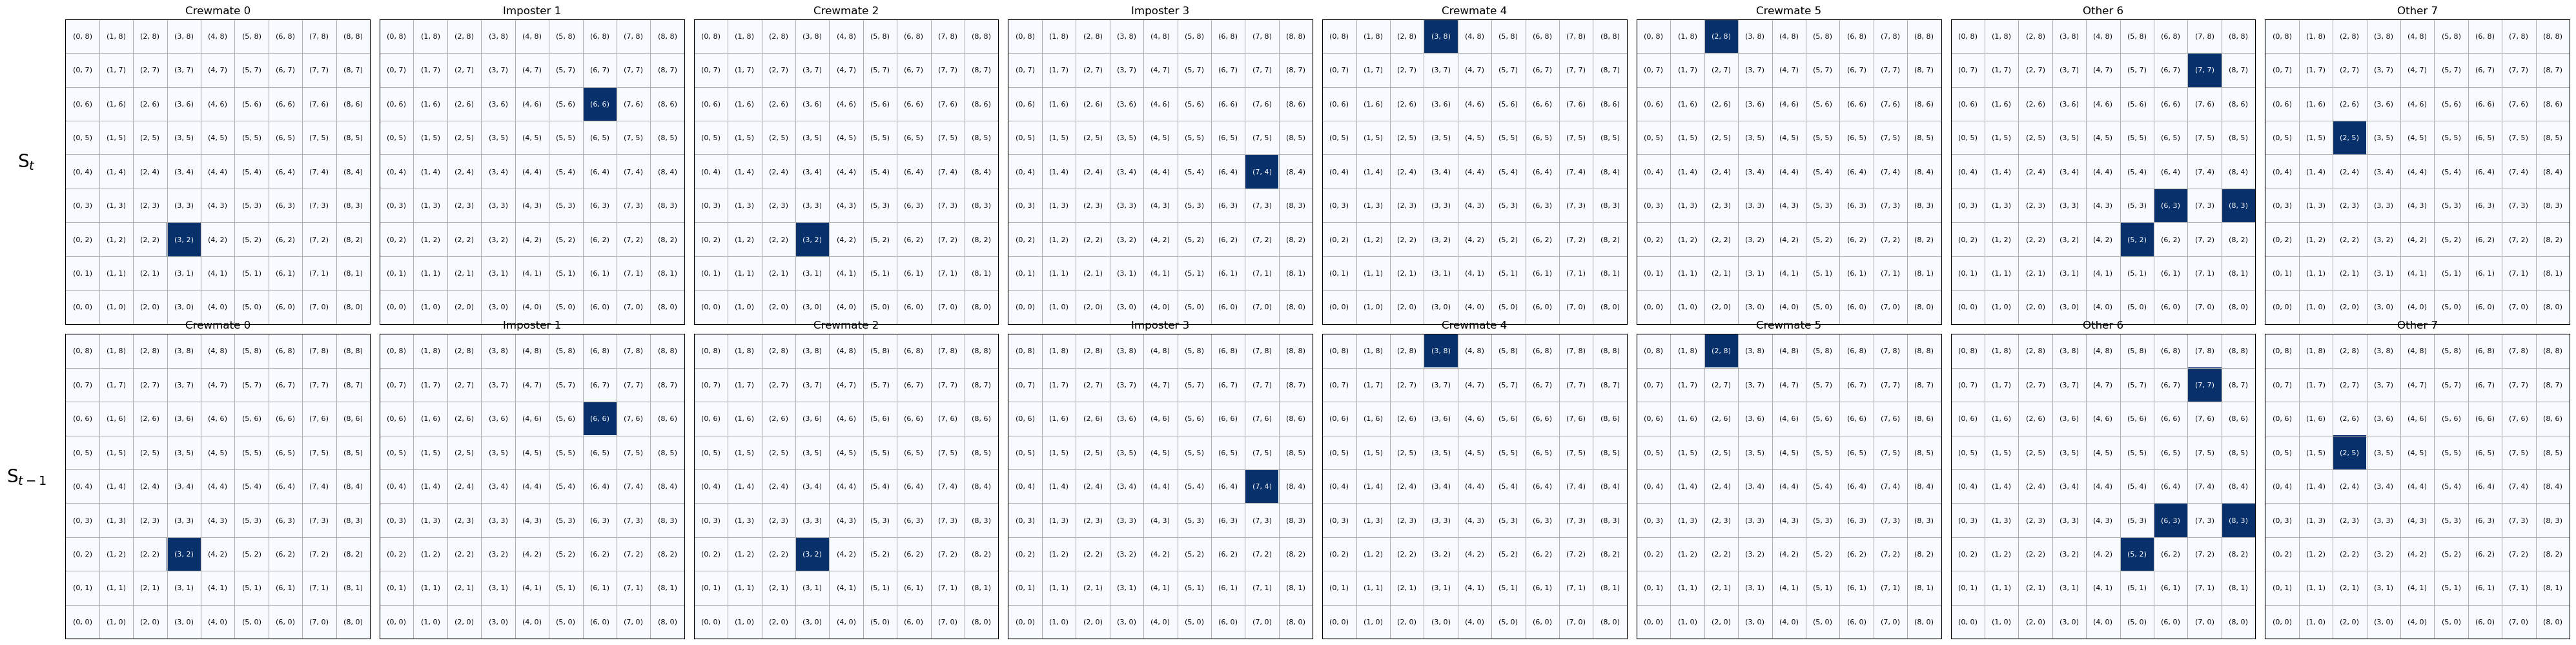

tensor([[1., 1., 1., 1., 1., 1., 2., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 1., 1., 1., 1., 1., 2., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])


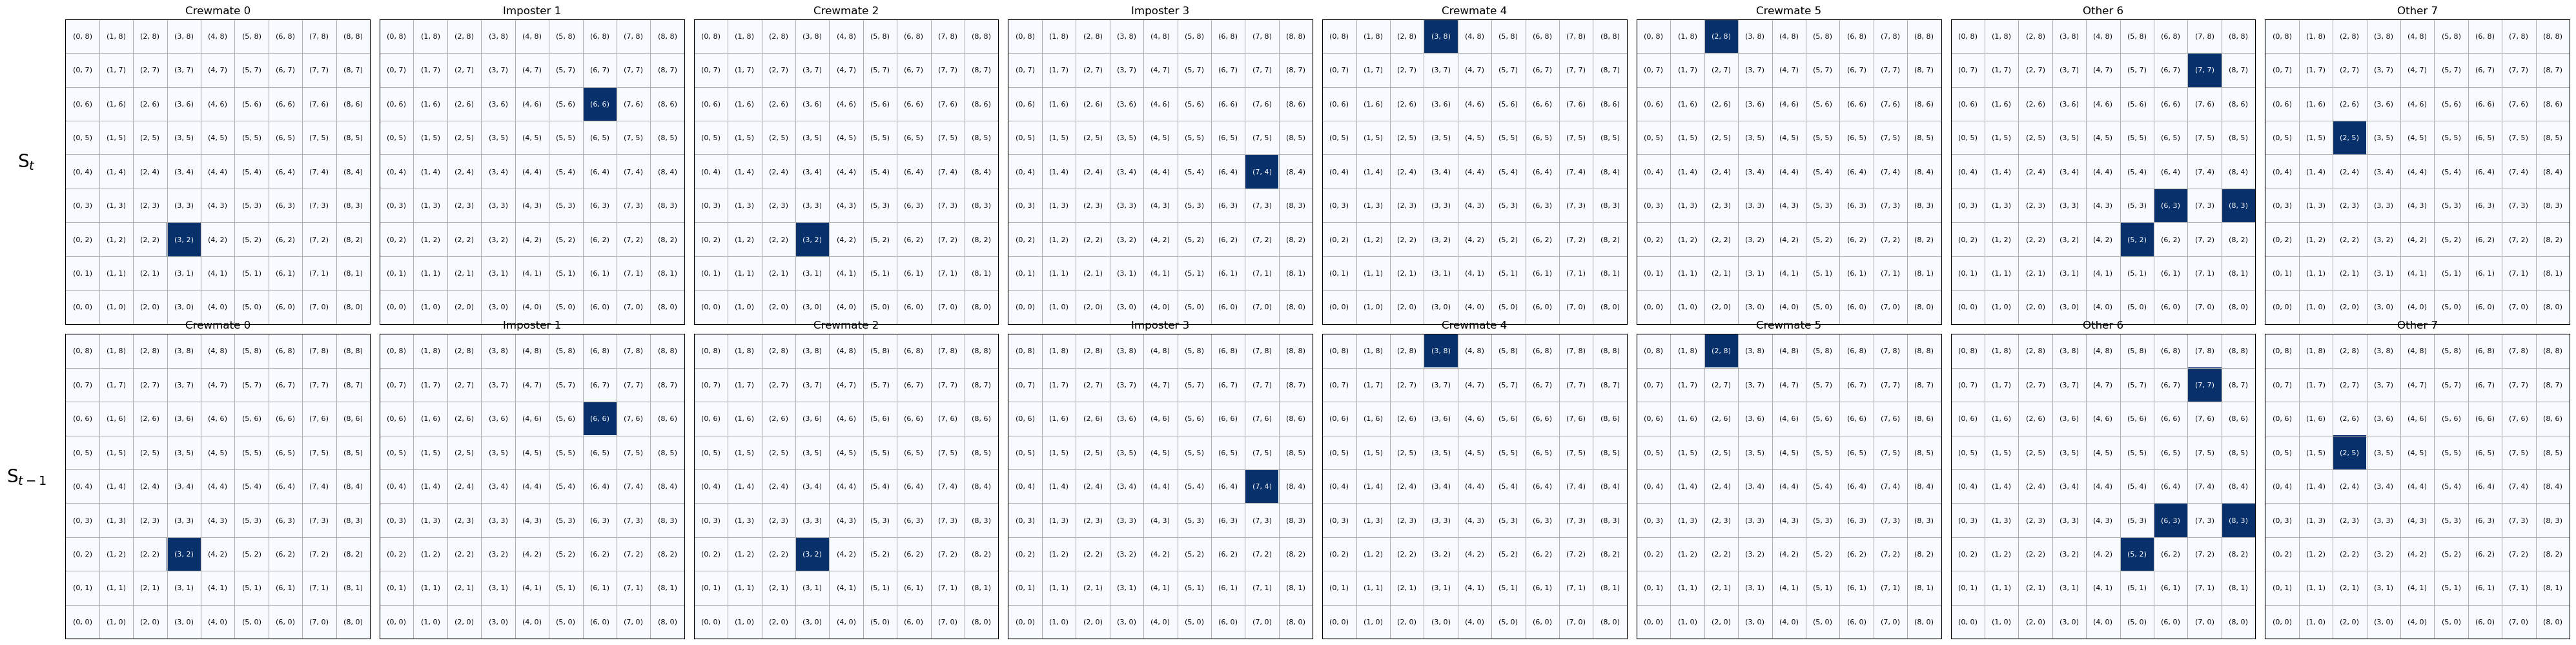

tensor([[1., 1., 1., 1., 1., 1., 2., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1., 1., 2., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


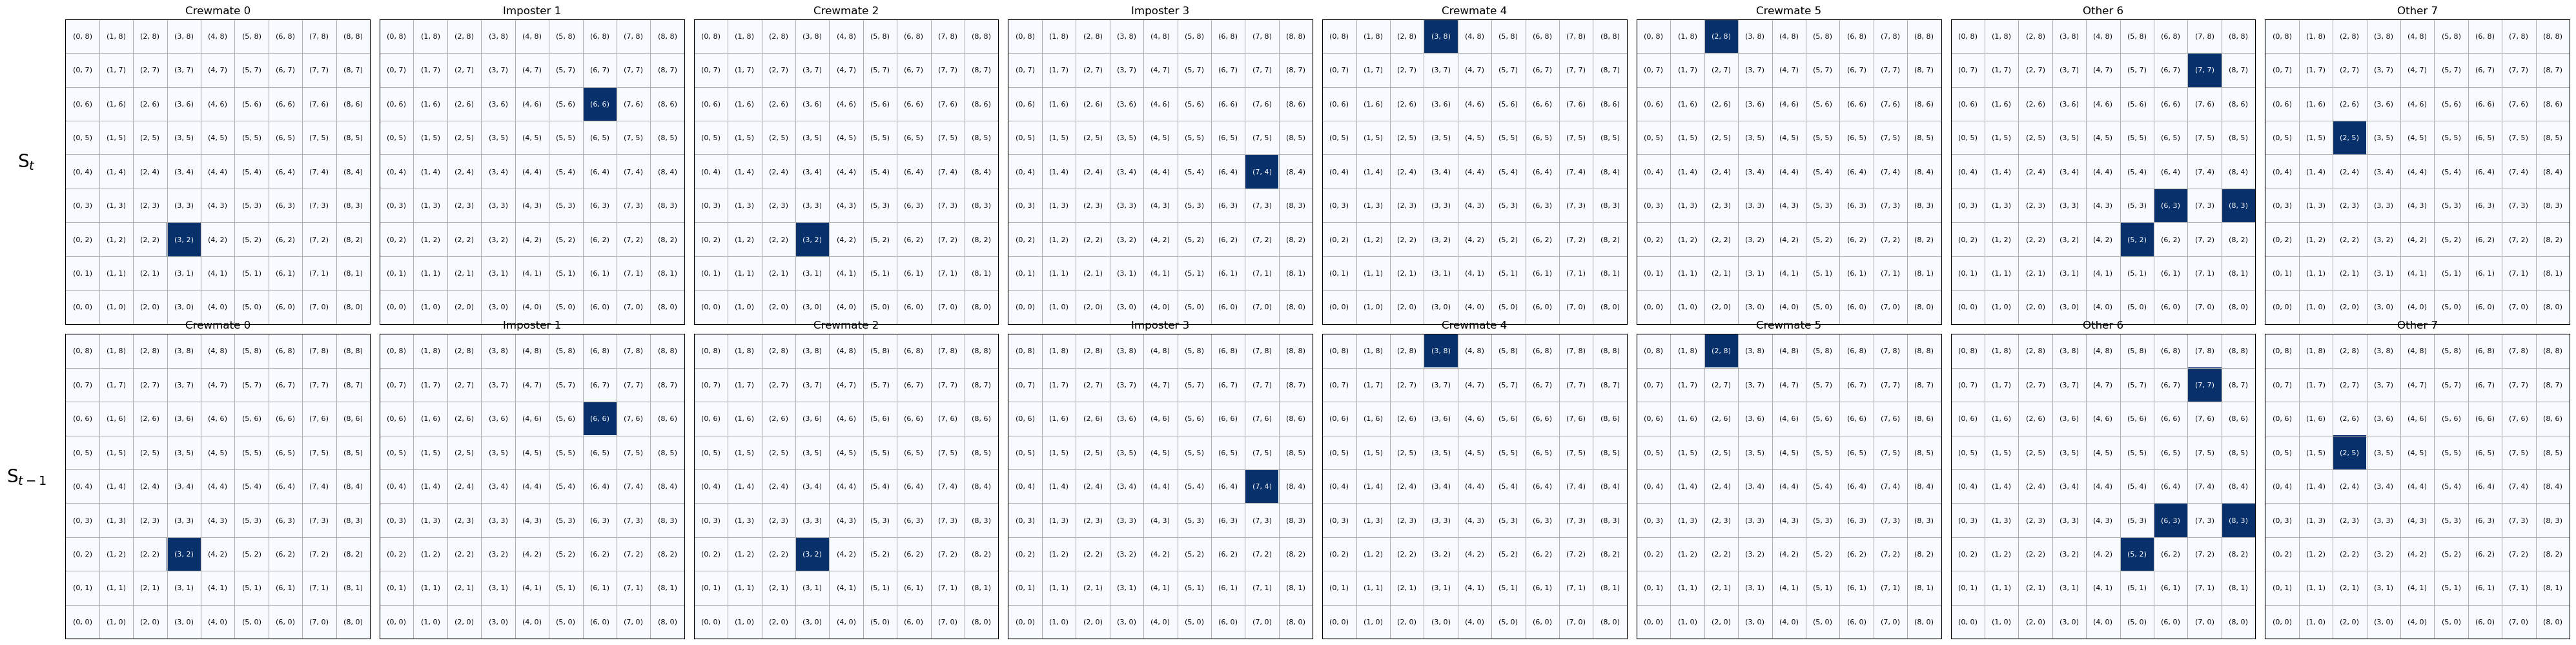

In [4]:
batch = m.sample(1)

seq_states = batch.states.squeeze(0)
seq_imposters = batch.imposters.squeeze(0)

f = GlobalFeaturizer(env, SEQUENCE_SIZE)
f.fit(seq_states, seq_imposters)
v = StateSequenceVisualizer(f)
v.visualize_perspectives()